# Title

## Description

## Imports & Setup

In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os
import pickle

## Data Loading

In [2]:
# data_path = '../data/processed/'

# # Define file paths
# D_1 = os.path.join(data_path, 'D-1', 'stress_binary_personal-current.pkl')
# D_2 = os.path.join(data_path, 'D-2', 'stress_binary_personal-current_D#3.pkl')
# D_3 = os.path.join(data_path, 'D-3', 'stress_binary_personal-current.pkl')

# # Load using pandas
# df_X_1, y_1, groups_1, t_1, datetimes_1 = pd.read_pickle(D_1)
# df_X_2, y_2, groups_2, t_2, datetimes_2 = pd.read_pickle(D_2)
# df_X_3, y_3, groups_3, t_3, datetimes_3 = pd.read_pickle(D_3)

In [3]:
data_path = '../data/processed/'

FILES = {
    'D-1': os.path.join(data_path, 'D-1', 'stress_binary_personal-current.pkl'),
    'D-2': os.path.join(data_path, 'D-2', 'stress_binary_personal-current_D#3.pkl'),
    'D-3': os.path.join(data_path, 'D-3', 'stress_binary_personal-current.pkl'),
}

def load_and_attach(path, dataset_tag):
    df, y, groups, t, datetimes = pd.read_pickle(path)

    # build meta once; light type-hints for memory
    meta = pd.DataFrame({
        'PIF#participantID': groups,
        'PIF#stress_label': y,
        'PIF#time_offset': t,
        'PIF#timestamp': datetimes,
        'META#dataset': dataset_tag,
    })

    assert len(df) == len(meta), f"Row mismatch in {dataset_tag}"

    out = pd.concat([df.reset_index(drop=True), meta.reset_index(drop=True)], axis=1)

    # keep meta first
    meta_cols = ['META#dataset', 'PIF#participantID', 'PIF#stress_label',
                 'PIF#time_offset', 'PIF#timestamp']
    return out[meta_cols + [c for c in out.columns if c not in meta_cols]]

df_X_1 = load_and_attach(FILES['D-1'], 'D-1')
df_X_2 = load_and_attach(FILES['D-2'], 'D-2')
df_X_3 = load_and_attach(FILES['D-3'], 'D-3')

In [4]:
# Before stacking run Column Normalization

# Row-wise append; keep all columns
df_X_combined = pd.concat(
    [df_X_1.assign(__src="D1"),
     df_X_2.assign(__src="D2"),
     df_X_3.assign(__src="D3")],
    axis=0,
    join="inner",
    ignore_index=True
)

## Initial Data Exploration

In [19]:
df_X_1.shape, df_X_2.shape, df_X_3.shape, df_X_combined.shape

((10075, 200), (20831, 233), (21619, 200), (52525, 118))

### Distribution analyses

In [20]:
df_X_combined

,META#dataset,PIF#participantID,PIF#stress_label,PIF#time_offset,PIF#timestamp,PIF#participationStartTimestamp,PIF#age,PIF#openness,PIF#conscientiousness,PIF#neuroticism,...,Notification_CAT#VAL=EVENT,Notification_CAT#VAL=ERROR,Notification_CAT#VAL=RECOMMENDATION,SCR_EVENT#VAL=ON,SCR_EVENT#VAL=OFF,SCR_EVENT#VAL=USER_PRESENT,SCR_DUR#VAL,MSG_SNT#VAL,__src,PIF#gender
0,D-1,P033,0,40609.415,2020-02-08 11:16:49.415000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,True,False,False,79.067001,0.0,D1,M
1,D-1,P033,0,47486.022,2020-02-08 13:11:26.022000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,True,False,False,1255.855957,0.0,D1,M
2,D-1,P033,0,50006.386,2020-02-08 13:53:26.386000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,False,False,True,0.799000,0.0,D1,M
3,D-1,P033,1,58937.042,2020-02-08 16:22:17.042000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,False,False,True,522.318970,0.0,D1,M
4,D-1,P033,1,62263.538,2020-02-08 17:17:43.538000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,True,False,False,384.083008,0.0,D1,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52520,D-3,P135,1,3672036.642,2022-01-05 12:00:36.642000+09:00,1.638922e+12,20.0,10.0,8.0,4.0,...,False,False,False,True,False,False,600.786987,1.0,D3,F
52521,D-3,P135,1,3676957.520,2022-01-05 13:22:37.520000+09:00,1.638922e+12,20.0,10.0,8.0,4.0,...,False,False,False,True,False,False,709.463989,1.0,D3,F
52522,D-3,P135,1,3691848.498,2022-01-05 17:30:48.498000+09:00,1.638922e+12,20.0,10.0,8.0,4.0,...,False,False,False,False,False,True,7454.271973,1.0,D3,F
52523,D-3,P135,1,3696341.705,2022-01-05 18:45:41.705000+09:00,1.638922e+12,20.0,10.0,8.0,4.0,...,False,False,False,False,False,True,27.683001,1.0,D3,F


In [21]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df_X_combined, title="Cross User Dataset Report")
# profile.to_file("df_X_combined_profile.html")

In [5]:
df_X_combined['PIF#gender'] = df_X_combined.apply(
    lambda row: 'F' if row['PIF#gender=F'] else 'M' if row['PIF#gender=M'] else None,
    axis=1
)
# Optionally drop the old one-hot columns
df_X_combined.drop(columns=['PIF#gender=F', 'PIF#gender=M'], inplace=True)

df_X_combined["PIF#gender"].value_counts()

/var/folders/f5/sr2lh_ld0y7140vy6w2xk4440000gn/T/ipykernel_5729/577576422.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_X_combined['PIF#gender'] = df_X_combined.apply(


PIF#gender
M    36466
F    16059
Name: count, dtype: int64

In [31]:
df_X_1

,META#dataset,PIF#participantID,PIF#stress_label,PIF#time_offset,PIF#timestamp,PIF#participationStartTimestamp,PIF#age,PIF#android,PIF#openness,PIF#conscientiousness,...,Sleep#Onset_TodayLateAfternoon,Sleep#Midpoint_TodayLateAfternoon,Sleep#Duration_TodayEvening,Sleep#Onset_TodayEvening,Sleep#Midpoint_TodayEvening,Sleep#Duration_TodayNight,Sleep#Onset_TodayNight,Sleep#Midpoint_TodayNight,MSG_SNT#VAL,PIF#device_type
0,D-1,P033,0,40609.415,2020-02-08 11:16:49.415000+09:00,1581119963136.0,30.0,9.0,10.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PIF#device=samsung-SM-G950N
1,D-1,P033,0,47486.022,2020-02-08 13:11:26.022000+09:00,1581119963136.0,30.0,9.0,10.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PIF#device=samsung-SM-G950N
2,D-1,P033,0,50006.386,2020-02-08 13:53:26.386000+09:00,1581119963136.0,30.0,9.0,10.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PIF#device=samsung-SM-G950N
3,D-1,P033,1,58937.042,2020-02-08 16:22:17.042000+09:00,1581119963136.0,30.0,9.0,10.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PIF#device=samsung-SM-G950N
4,D-1,P033,1,62263.538,2020-02-08 17:17:43.538000+09:00,1581119963136.0,30.0,9.0,10.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PIF#device=samsung-SM-G950N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10070,D-1,P138,0,4310332.717,2020-03-28 21:18:52.717000+09:00,1582848016384.0,21.0,9.0,8.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PIF#device=samsung-SM-G885S
10071,D-1,P138,0,4364048.818,2020-03-29 12:14:08.818000+09:00,1582848016384.0,21.0,9.0,8.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PIF#device=samsung-SM-G885S
10072,D-1,P138,0,4379381.637,2020-03-29 16:29:41.637000+09:00,1582848016384.0,21.0,9.0,8.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PIF#device=samsung-SM-G885S
10073,D-1,P138,1,4443941.837,2020-03-30 10:25:41.837000+09:00,1582848016384.0,21.0,9.0,8.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PIF#device=samsung-SM-G885S


In [44]:
df_X_combined

,META#dataset,PIF#participantID,PIF#stress_label,PIF#time_offset,PIF#timestamp,PIF#participationStartTimestamp,PIF#age,PIF#openness,PIF#conscientiousness,PIF#neuroticism,...,Notification_CAT#VAL=EVENT,Notification_CAT#VAL=ERROR,Notification_CAT#VAL=RECOMMENDATION,SCR_EVENT#VAL=ON,SCR_EVENT#VAL=OFF,SCR_EVENT#VAL=USER_PRESENT,SCR_DUR#VAL,MSG_SNT#VAL,__src,PIF#gender
0,D-1,P033,0,40609.415,2020-02-08 11:16:49.415000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,True,False,False,79.067001,0.0,D1,M
1,D-1,P033,0,47486.022,2020-02-08 13:11:26.022000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,True,False,False,1255.855957,0.0,D1,M
2,D-1,P033,0,50006.386,2020-02-08 13:53:26.386000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,False,False,True,0.799000,0.0,D1,M
3,D-1,P033,1,58937.042,2020-02-08 16:22:17.042000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,False,False,True,522.318970,0.0,D1,M
4,D-1,P033,1,62263.538,2020-02-08 17:17:43.538000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,True,False,False,384.083008,0.0,D1,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52520,D-3,P135,1,3672036.642,2022-01-05 12:00:36.642000+09:00,1.638922e+12,20.0,10.0,8.0,4.0,...,False,False,False,True,False,False,600.786987,1.0,D3,F
52521,D-3,P135,1,3676957.520,2022-01-05 13:22:37.520000+09:00,1.638922e+12,20.0,10.0,8.0,4.0,...,False,False,False,True,False,False,709.463989,1.0,D3,F
52522,D-3,P135,1,3691848.498,2022-01-05 17:30:48.498000+09:00,1.638922e+12,20.0,10.0,8.0,4.0,...,False,False,False,False,False,True,7454.271973,1.0,D3,F
52523,D-3,P135,1,3696341.705,2022-01-05 18:45:41.705000+09:00,1.638922e+12,20.0,10.0,8.0,4.0,...,False,False,False,False,False,True,27.683001,1.0,D3,F


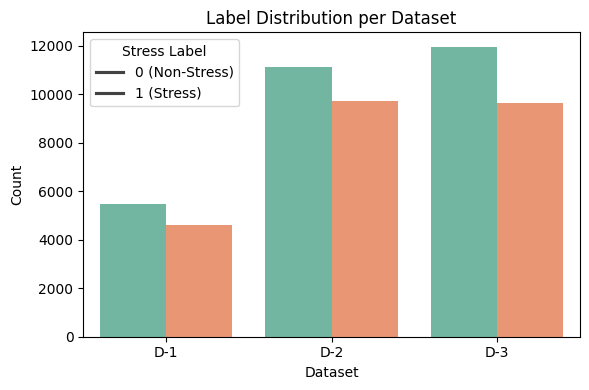

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate counts
label_counts = (
    df_X_combined.groupby(['META#dataset', 'PIF#stress_label'])
    .size()
    .reset_index(name='count')
)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(
    data=label_counts,
    x='META#dataset',
    y='count',
    hue='PIF#stress_label',
    palette='Set2'
)

plt.title('Label Distribution per Dataset')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.legend(title='Stress Label', labels=['0 (Non-Stress)', '1 (Stress)'])
plt.tight_layout()
plt.show()


In [33]:
df_X_combined = pd.read_pickle('df_X_combined.pkl')

/var/folders/f5/sr2lh_ld0y7140vy6w2xk4440000gn/T/ipykernel_5729/4215643087.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gender', title_fontsize=12, fontsize=11, frameon=True, fancybox=True, shadow=False)


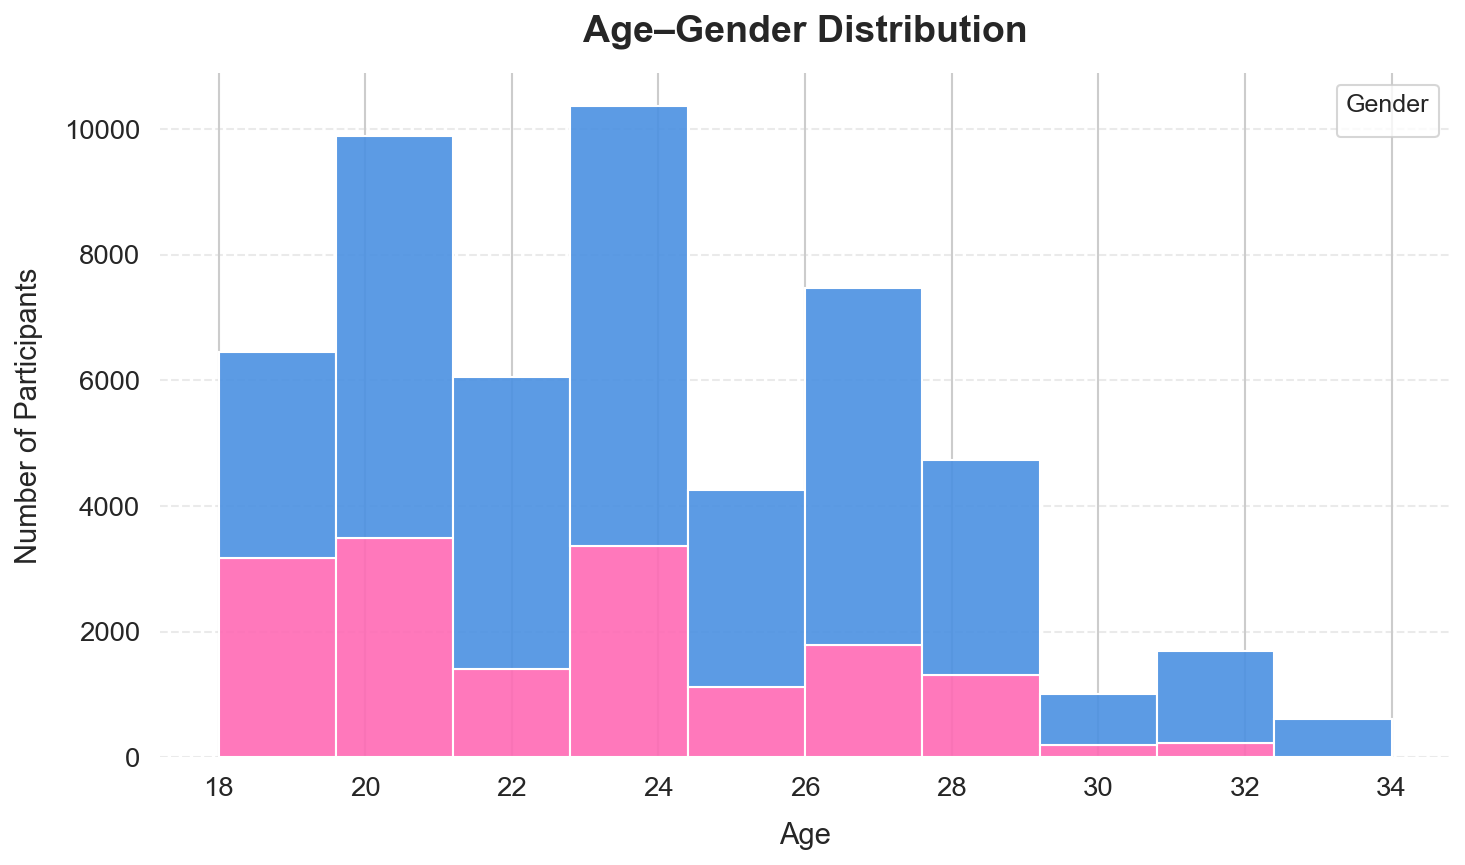

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare gender & age columns ---
df_X_combined['PIF#gender'] = df_X_combined['PIF#gender'].str.upper()
df_X_combined['PIF#age'] = df_X_combined.filter(regex='(?i)PIF#age').bfill(axis=1).iloc[:, 0]

# --- Define a refined palette ---
gender_palette = {'M': '#4A90E2', 'F': '#FF69B4'}

# --- Configure plot style ---
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6), dpi=150)

# --- Draw the histogram ---
sns.histplot(
    data=df_X_combined,
    x='PIF#age',
    hue='PIF#gender',
    multiple='stack',
    bins=10,
    palette=gender_palette,
    edgecolor='white',
    alpha=0.9
)

# --- Beautify the plot ---
plt.title('Age–Gender Distribution', fontsize=18, weight='bold', pad=15)
plt.xlabel('Age', fontsize=14, labelpad=10)
plt.ylabel('Number of Participants', fontsize=14, labelpad=10)
plt.legend(title='Gender', title_fontsize=12, fontsize=11, frameon=True, fancybox=True, shadow=False)
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine(left=True, bottom=True)

# --- Tight layout for paper look ---
plt.tight_layout()
plt.show()


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pid_col   = "PIF#participantID"
ts_col    = "PIF#timestamp"
start_col = "PIF#participationStartTimestamp"
# --- 1) Robust timestamp normalization (auto-detect per-value unit) ---
# Heuristic bands (Unix epoch):
# seconds   ~ 1e9      (2001–2038)
# millis    ~ 1e12     (2001–2286)
# micros    ~ 1e15
# nanos     ~ 1e18
def _to_ms_array(x: pd.Series) -> np.ndarray:
    v = pd.to_numeric(x, errors="coerce").to_numpy(dtype="float64")
    ms = np.full(v.shape, np.nan, dtype="float64")

    m_sec  = (v > 1e8)   & (v < 1e11)   # 3–4-digit years around now
    m_ms   = (v >= 1e11) & (v < 1e14)
    m_us   = (v >= 1e14) & (v < 1e17)
    m_ns   = (v >= 1e17) & (v < 1e20)

    ms[m_sec] = v[m_sec] * 1e3
    ms[m_ms]  = v[m_ms]
    ms[m_us]  = v[m_us] / 1e3
    ms[m_ns]  = v[m_ns] / 1e6

    # Fallback: try parsing as ISO-like strings where numeric failed
    mask_nan = np.isnan(ms)
    if mask_nan.any():
        dt_str = pd.to_datetime(x[mask_nan], utc=True, errors="coerce")
        ms[mask_nan] = dt_str.view("int64") / 1e6  # ns -> ms

    return ms

def robust_to_utc_datetime(s: pd.Series) -> pd.Series:
    ms = _to_ms_array(s)
    # Keep only a sane window (2010-01-01 .. 2035-12-31) to drop junk
    min_ms = pd.Timestamp("2010-01-01", tz="UTC").value / 1e6
    max_ms = pd.Timestamp("2035-12-31", tz="UTC").value / 1e6
    valid = (ms >= min_ms) & (ms <= max_ms)
    out = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns, UTC]")
    out[valid] = pd.to_datetime(ms[valid], unit="ms", utc=True)
    return out

# --- Parse absolute timestamps and participation starts ---
ts_utc    = robust_to_utc_datetime(df_X_1[ts_col])
start_utc = robust_to_utc_datetime(df_X_1[start_col])

# Drop rows we cannot trust
ok = ts_utc.notna() & start_utc.notna()
df = df_X_1.loc[ok].copy()
df["_ts_utc"]    = ts_utc.loc[ok]
df["_start_utc"] = start_utc.loc[ok]
df["_ts_local"]  = df["_ts_utc"].dt.tz_convert("Asia/Seoul")

# Compute offset in HOURS (ns diff -> hours)
df["_offset_hours"] = (df["_ts_utc"].view("int64") - df["_start_utc"].view("int64")) / (1e9 * 3600)

/var/folders/f5/sr2lh_ld0y7140vy6w2xk4440000gn/T/ipykernel_5729/4103171690.py:32: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ms[mask_nan] = dt_str.view("int64") / 1e6  # ns -> ms
/var/folders/f5/sr2lh_ld0y7140vy6w2xk4440000gn/T/ipykernel_5729/4103171690.py:58: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["_offset_hours"] = (df["_ts_utc"].view("int64") - df["_start_utc"].view("int64")) / (1e9 * 3600)
/var/folders/f5/sr2lh_ld0y7140vy6w2xk4440000gn/T/ipykernel_5729/4103171690.py:58: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["_offset_hours"] = (df["_ts_utc"].view("int64") - df["_start_utc"].view("int64")) / (1e9 * 3600)


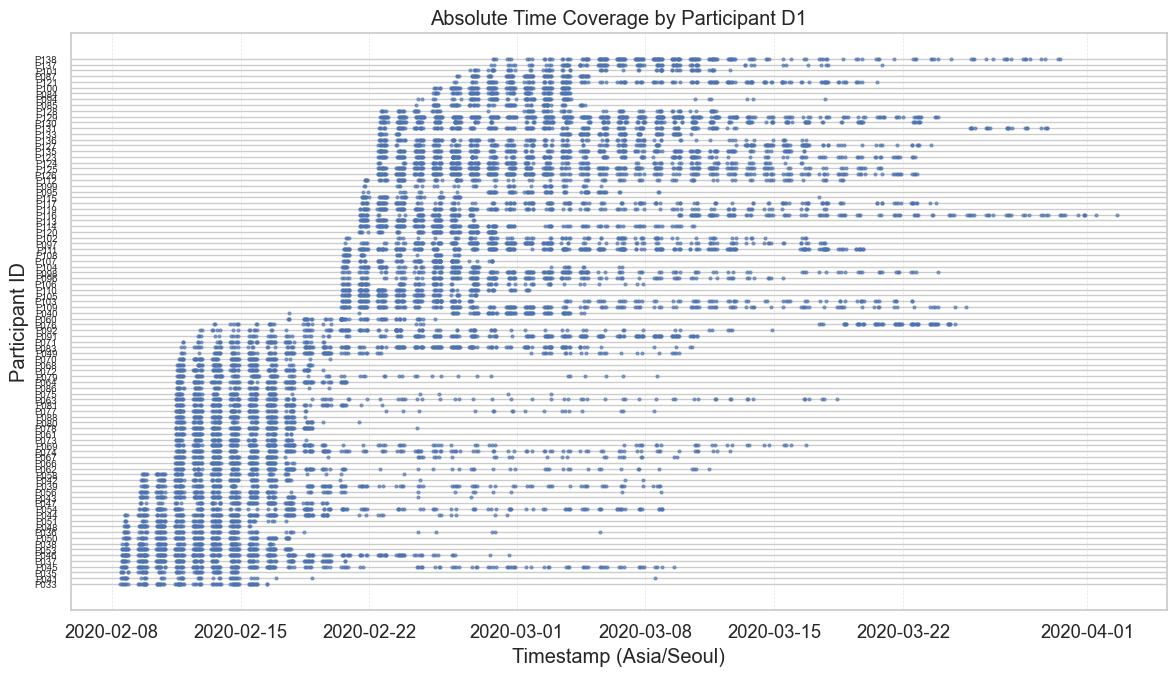

In [57]:

# Absolute Time Coverage (scatter by participant)
# (auto-order participants by first seen)
first_seen = df.groupby(pid_col)["_ts_local"].min().sort_values()
ordered_pids = first_seen.index.tolist()
y_map = {p: i for i, p in enumerate(ordered_pids)}
df["_y_abs"] = df[pid_col].map(y_map)

plt.figure(figsize=(12, 7))
plt.scatter(df["_ts_local"], df["_y_abs"], s=4, alpha=0.6)
plt.yticks(range(len(ordered_pids)), ordered_pids, fontsize=7)
plt.xlabel("Timestamp (Asia/Seoul)")
plt.ylabel("Participant ID")
plt.title("Absolute Time Coverage by Participant D1")
plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


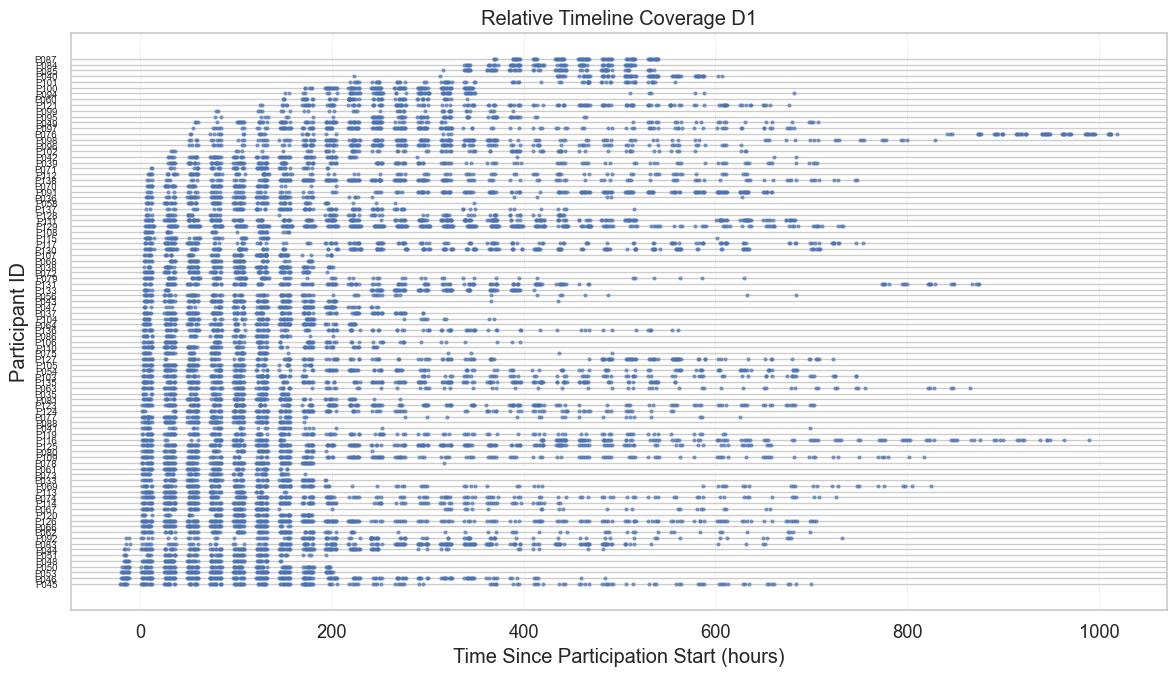

In [56]:
# --- 3) Relative Timeline Coverage (everyone on same clock) ---
first_seen_off = df.groupby(pid_col)["_offset_hours"].min().sort_values()
ordered_pids_off = first_seen_off.index.tolist()
y_map_off = {p: i for i, p in enumerate(ordered_pids_off)}
df["_y_rel"] = df[pid_col].map(y_map_off)

plt.figure(figsize=(12, 7))
plt.scatter(df["_offset_hours"], df["_y_rel"], s=4, alpha=0.6)
plt.yticks(range(len(ordered_pids_off)), ordered_pids_off, fontsize=7)
plt.xlabel("Time Since Participation Start (hours)")
plt.ylabel("Participant ID")
plt.title("Relative Timeline Coverage D1")
plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

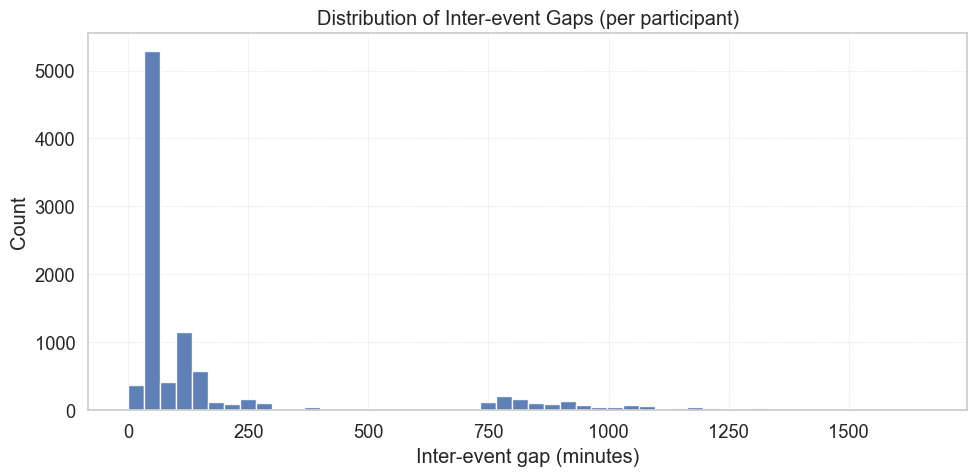

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Use whichever timestamp column you have
time_col = "_ts_utc" if "_ts_utc" in df.columns else "_ts_local"

# Sort once, compute per-participant diffs (minutes)
s = (
    df.sort_values([pid_col, time_col])
      .set_index(pid_col)[time_col]
)

gaps_min = s.groupby(level=0).diff().dt.total_seconds() / 60.0

# Drop NaNs/negatives (first events, clock issues)
gaps_min = gaps_min[gaps_min > 0]

# Clip extreme outliers at 99th percentile for visualization
p99 = np.nanpercentile(gaps_min, 99)
gaps_clip = gaps_min[gaps_min <= p99]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(gaps_clip, bins=50, edgecolor="white", alpha=0.9)
ax.set_xlabel("Inter-event gap (minutes)")
ax.set_ylabel("Count")
ax.set_title("Distribution of Inter-event Gaps (per participant)")
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


In [43]:
df_X_combined['PIF#participantID'].nunique()

136

In [ ]:
pid_col = "PIF#participantID"
ts_col  = "PIF#timestamp"

def parse_mixed_timestamp(s):
    # Try parsing as datetime directly (handles ISO, already datetime, etc.)
    dt = pd.to_datetime(s, utc=True, errors="coerce")
    
    # If failed (likely numeric), try numeric -> datetime (infers ms or s)
    mask = dt.isna()
    if mask.any():
        s_num = pd.to_numeric(s[mask], errors="coerce")
        # infer scale: if large → ms, else → s
        if not s_num.empty:
            unit = "ms" if s_num.median() > 1e12 else "s"
            dt_num = pd.to_datetime(s_num, unit=unit, utc=True, errors="coerce")
            dt.loc[mask] = dt_num
    return dt.sort_values()

def inter_event_minutes(group):
    t = parse_mixed_timestamp(group[ts_col]).dropna()
    if len(t) < 2:
        return pd.Series(dtype=float)
    gaps = t.diff().dt.total_seconds() / 60
    return gaps.dropna()

gaps_all = df_X_combined.groupby(pid_col, group_keys=False).apply(inter_event_minutes)

summary = gaps_all.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).round(2)
print("\n=== Inter-event Gap Summary (minutes) ===")
print(summary)



=== Inter-event Gap Summary (minutes) ===
count     52389.00
mean       1778.83
std       29739.31
min           0.00
10%          44.60
25%          56.47
50%          76.99
75%         142.16
90%         827.06
max      941998.29
Name: PIF#timestamp, dtype: float64


/var/folders/f5/sr2lh_ld0y7140vy6w2xk4440000gn/T/ipykernel_1763/2647129530.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaps_all = df_X_combined.groupby(pid_col, group_keys=False).apply(inter_event_minutes)


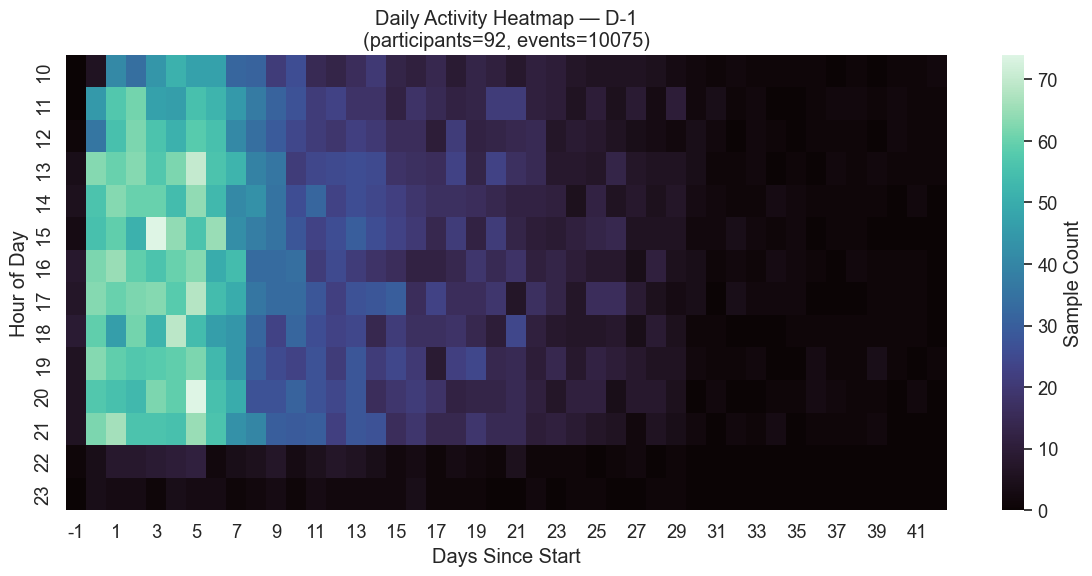

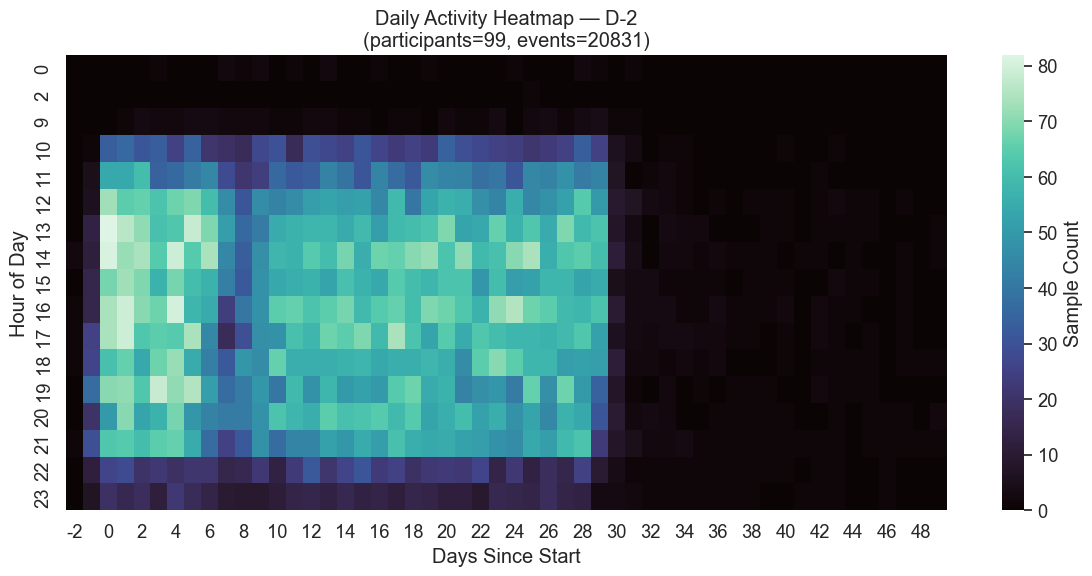

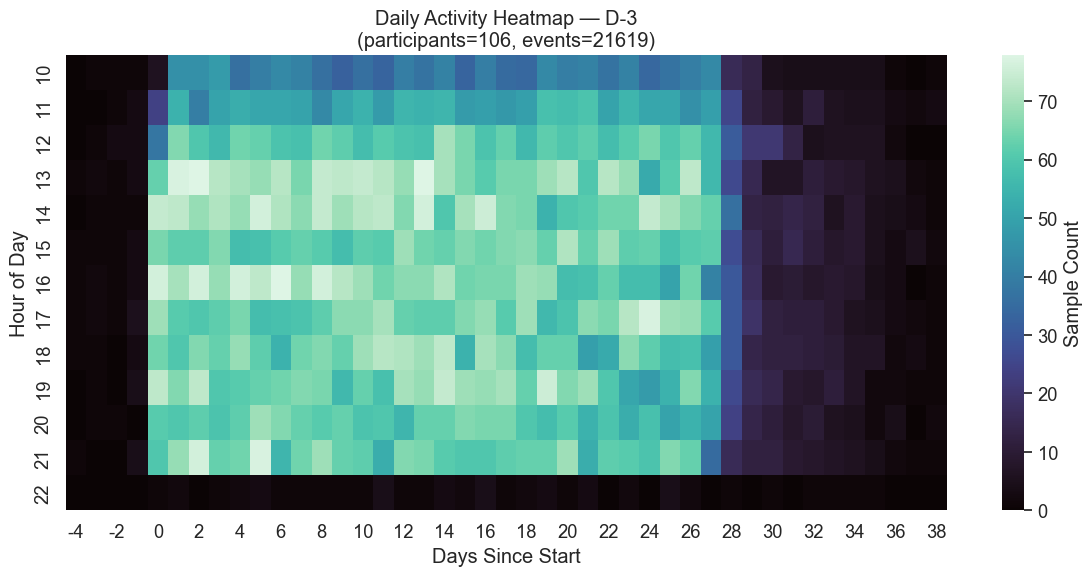

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ds_col  = "META#dataset"
ts_col  = "PIF#timestamp"
start_col = "PIF#participationStartTimestamp"
pid_col = "PIF#participantID"

# --- Parse both columns to timezone-aware datetimes in Asia/Seoul ---
# ts: can be ISO already; fall back to numeric if needed
ts_dt = pd.to_datetime(df_X_combined[ts_col], errors="coerce", utc=True)
# if some rows are naive or already tz-aware in local, coerce via to_datetime again
ts_dt = ts_dt.dt.tz_convert("Asia/Seoul")

# start: stored as ms since epoch (float) -> datetime
start_dt = pd.to_datetime(df_X_combined[start_col], unit="ms", errors="coerce", utc=True).dt.tz_convert("Asia/Seoul")

# keep rows that have both timestamps
ok = ts_dt.notna() & start_dt.notna()
base = df_X_combined.loc[ok, [ds_col, pid_col]].copy()

# build derived fields in one go to avoid fragmentation warnings
base = base.assign(
    datetime = ts_dt.loc[ok],
    start_dt = start_dt.loc[ok],
)

# day index since participation start (floor to days)
delta_days = (base["datetime"] - base["start_dt"]).dt.total_seconds() / 86400.0
base["day_index"] = np.floor(delta_days).astype("int64")
base["hour"] = base["datetime"].dt.hour

# --- heatmap helper ---
def plot_daily_hour_heatmap(dsub: pd.DataFrame, title_suffix: str):
    if dsub.empty:
        print(f"[skip] {title_suffix}: empty after parsing")
        return
    heat = (
        dsub.groupby(["day_index", "hour"])
            .size()
            .unstack(fill_value=0)
            .sort_index()
    )
    # nice bounds: focus on observed day range
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        heat.T, cmap="mako", cbar_kws={"label": "Sample Count"},
        square=False
    )
    plt.title(f"Daily Activity Heatmap — {title_suffix}\n"
              f"(participants={dsub[pid_col].nunique()}, events={len(dsub)})")
    plt.xlabel("Days Since Start")
    plt.ylabel("Hour of Day")
    plt.tight_layout()
    plt.show()

# --- run per dataset (D-1/D-2/D-3) ---
for ds in ("D-1", "D-2", "D-3"):
    dsub = base.loc[base[ds_col] == ds, ["day_index", "hour", pid_col]]
    plot_daily_hour_heatmap(dsub, ds)


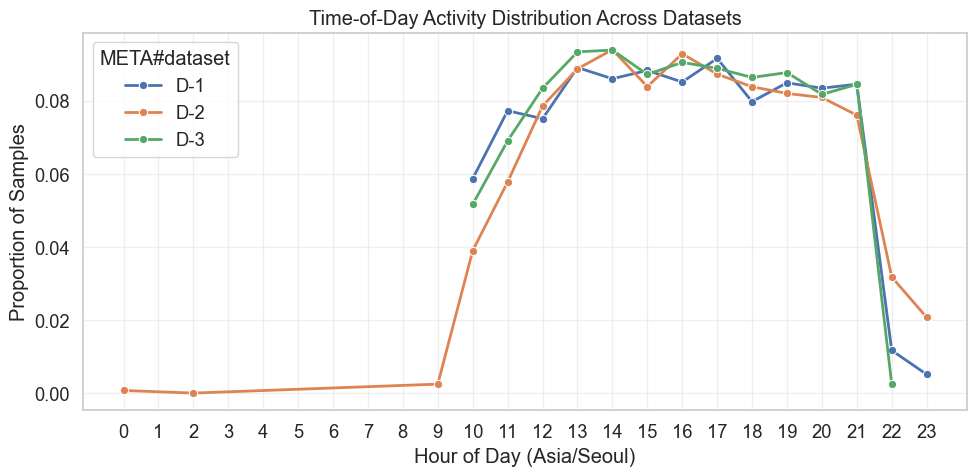

In [62]:
# Time-of-Day Sample Distribution

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Make sure we reuse the parsed datetime from earlier ---
if "datetime" not in base.columns:
    base["datetime"] = pd.to_datetime(df_X_combined["PIF#timestamp"], errors="coerce", utc=True).dt.tz_convert("Asia/Seoul")

# --- Compute sample count per hour ---
hourly = (
    base.assign(hour=base["datetime"].dt.hour)
        .groupby(["META#dataset", "hour"])
        .size()
        .reset_index(name="sample_count")
)

# --- Normalize (optional) so that each dataset sums to 1.0 ---
hourly["proportion"] = hourly.groupby("META#dataset")["sample_count"].transform(lambda x: x / x.sum())

# --- Plot ---
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=hourly,
    x="hour",
    y="proportion",
    hue="META#dataset",
    marker="o",
    linewidth=2.0,
)
plt.xticks(range(0, 24))
plt.xlabel("Hour of Day (Asia/Seoul)")
plt.ylabel("Proportion of Samples")
plt.title("Time-of-Day Activity Distribution Across Datasets")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



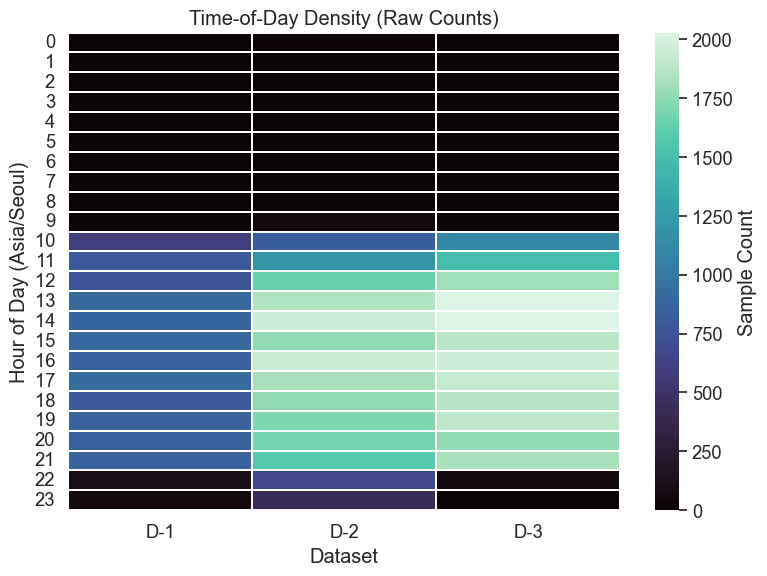

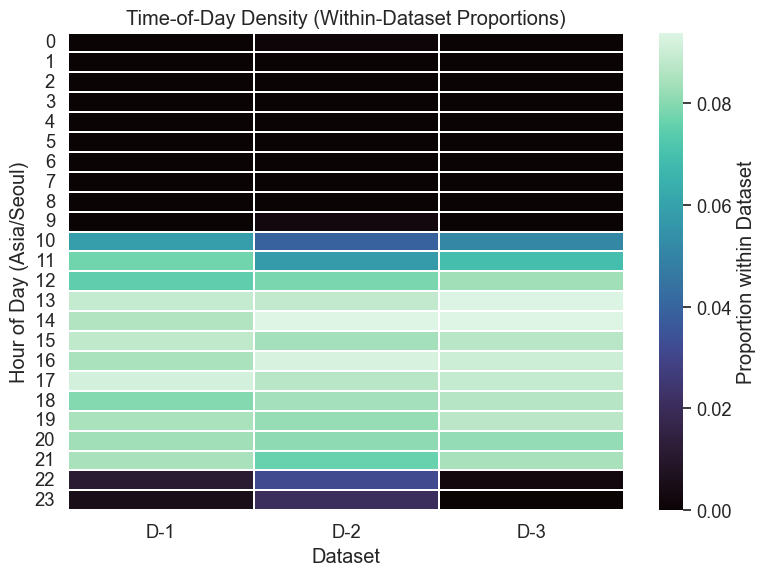

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ds_col = "META#dataset"
ts_col = "PIF#timestamp"

# --- Make sure we have a local-time datetime to extract hour ---
if "datetime" in locals() and isinstance(datetime, pd.Series):
    dt_local = datetime  # reuse if you already built it
else:
    dt_local = pd.to_datetime(df_X_combined[ts_col], errors="coerce", utc=True).dt.tz_convert("Asia/Seoul")

df_hour = (
    df_X_combined
      .assign(datetime=dt_local)
      .loc[dt_local.notna(), [ds_col, "datetime"]]
      .assign(hour=lambda d: d["datetime"].dt.hour)
)

# --- 1) Heatmap of RAW COUNTS (hours x dataset) ---
counts = (
    df_hour.groupby(["hour", ds_col])
           .size()
           .unstack(fill_value=0)
           .reindex(range(24), fill_value=0)  # ensure all 24 hours present
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    counts,
    cmap="mako",
    cbar_kws={"label": "Sample Count"},
    linewidths=0.3,
    linecolor="white"
)
plt.title("Time-of-Day Density (Raw Counts)")
plt.xlabel("Dataset")
plt.ylabel("Hour of Day (Asia/Seoul)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 2) Heatmap of WITHIN-DATASET PROPORTIONS (column-normalized) ---
props = counts / counts.sum(axis=0).replace(0, np.nan)

plt.figure(figsize=(8, 6))
sns.heatmap(
    props,
    cmap="mako",
    cbar_kws={"label": "Proportion within Dataset"},
    vmin=0, vmax=props.max().max(),
    linewidths=0.3,
    linecolor="white"
)
plt.title("Time-of-Day Density (Within-Dataset Proportions)")
plt.xlabel("Dataset")
plt.ylabel("Hour of Day (Asia/Seoul)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [60]:
df_X_combined

,META#dataset,PIF#participantID,PIF#stress_label,PIF#time_offset,PIF#timestamp,PIF#participationStartTimestamp,PIF#age,PIF#openness,PIF#conscientiousness,PIF#neuroticism,...,Notification_CAT#VAL=EVENT,Notification_CAT#VAL=ERROR,Notification_CAT#VAL=RECOMMENDATION,SCR_EVENT#VAL=ON,SCR_EVENT#VAL=OFF,SCR_EVENT#VAL=USER_PRESENT,SCR_DUR#VAL,MSG_SNT#VAL,__src,PIF#gender
0,D-1,P033,0,40609.415,2020-02-08 11:16:49.415000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,True,False,False,79.067001,0.0,D1,M
1,D-1,P033,0,47486.022,2020-02-08 13:11:26.022000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,True,False,False,1255.855957,0.0,D1,M
2,D-1,P033,0,50006.386,2020-02-08 13:53:26.386000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,False,False,True,0.799000,0.0,D1,M
3,D-1,P033,1,58937.042,2020-02-08 16:22:17.042000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,False,False,True,522.318970,0.0,D1,M
4,D-1,P033,1,62263.538,2020-02-08 17:17:43.538000+09:00,1.581120e+12,30.0,10.0,13.0,7.0,...,False,False,False,True,False,False,384.083008,0.0,D1,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52520,D-3,P135,1,3672036.642,2022-01-05 12:00:36.642000+09:00,1.638922e+12,20.0,10.0,8.0,4.0,...,False,False,False,True,False,False,600.786987,1.0,D3,F
52521,D-3,P135,1,3676957.520,2022-01-05 13:22:37.520000+09:00,1.638922e+12,20.0,10.0,8.0,4.0,...,False,False,False,True,False,False,709.463989,1.0,D3,F
52522,D-3,P135,1,3691848.498,2022-01-05 17:30:48.498000+09:00,1.638922e+12,20.0,10.0,8.0,4.0,...,False,False,False,False,False,True,7454.271973,1.0,D3,F
52523,D-3,P135,1,3696341.705,2022-01-05 18:45:41.705000+09:00,1.638922e+12,20.0,10.0,8.0,4.0,...,False,False,False,False,False,True,27.683001,1.0,D3,F


### Sensors

### Plots

  META#dataset PIF#participantID  PIF#stress_label  PIF#time_offset  \
0          D-1              P033                 0        40609.415   
1          D-1              P033                 0        47486.022   
2          D-1              P033                 0        50006.386   
3          D-1              P033                 1        58937.042   
4          D-1              P033                 1        62263.538   

                     PIF#timestamp  PIF#participationStartTimestamp  PIF#age  \
0 2020-02-08 11:16:49.415000+09:00                     1.581120e+12     30.0   
1 2020-02-08 13:11:26.022000+09:00                     1.581120e+12     30.0   
2 2020-02-08 13:53:26.386000+09:00                     1.581120e+12     30.0   
3 2020-02-08 16:22:17.042000+09:00                     1.581120e+12     30.0   
4 2020-02-08 17:17:43.538000+09:00                     1.581120e+12     30.0   

   PIF#android  PIF#openness  PIF#conscientiousness  ...  \
0          9.0          10.0    

100%|██████████| 10075/10075 [00:00<00:00, 28006.60it/s]


device_label
samsung-SM-A750N    455.829193
LGE-LGM-G600K       454.975616
samsung-SM-N935K    453.711121
LGE-LGM-V300K       452.251099
samsung-SM-A505N    450.982330
samsung-SM-A908N    449.183533
LGE-LM-X625N        430.659607
samsung-SM-A305N    426.660431
samsung-SM-G955N    412.624390
LGE-LGM-V300S       406.260162
samsung-SM-G950N    389.723999
samsung-SM-G930L    382.877716
samsung-SM-G930S    381.018799
LGE-LGM-V300L       377.627441
HUAWEI-ELE-L29      375.052948
samsung-SM-N971N    370.939117
samsung-SM-G960N    369.222412
LGE-LM-G710N        368.758545
samsung-SM-N950N    365.438080
samsung-SM-N960N    364.018372
Name: sleep_hours, dtype: float32


/var/folders/f5/sr2lh_ld0y7140vy6w2xk4440000gn/T/ipykernel_11142/563940239.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grp_plot.values, y=grp_plot.index, palette='viridis')


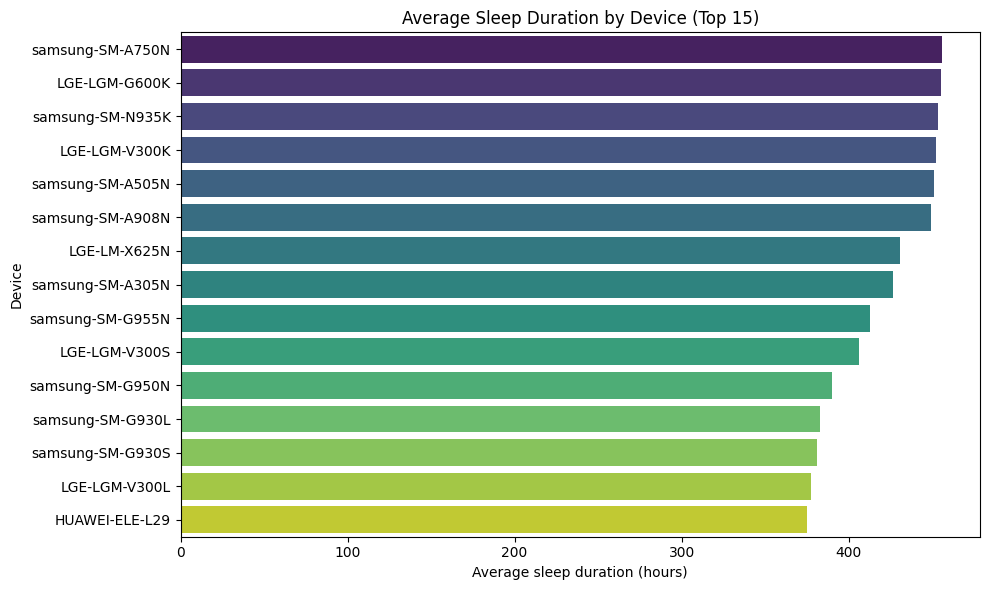

In [8]:
# Purpose: Load the provided CSV, inspect columns, compute average sleep duration by device, and visualize differences.
# Keeping it concise and methodical per instructions.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Load data
df_stress = df_X_1

# Basic preview
print(df_stress.head())

# Identify likely device and sleep columns based on known prefixes from preview metadata
possible_device_cols = [c for c in df_stress.columns if c.startswith('PIF#device=')]
# There may be a binary one-hot per device; create a single device label choosing the active one, else Unknown

def pick_device(row):
    active = [c for c in possible_device_cols if row.get(c, 0) == 1]
    if len(active) == 1:
        return active[0].split('=')[-1]
    if len(active) > 1:
        return 'Multiple'
    return 'Unknown'

# Sleep duration column candidates
sleep_cols = [c for c in df_stress.columns if 'Sleep#Duration' in c or c == 'Sleep#Duration']

print(possible_device_cols[:10])
print(sleep_cols)

# Build device label once
if 'device_label' not in df_stress.columns:
    tqdm.pandas()
    df_stress['device_label'] = df_stress.progress_apply(pick_device, axis=1)

# Get sleep duration numeric in hours if needed.
# Often Sleep#Duration may already be in hours; coerce to numeric.
if len(sleep_cols) > 0:
    sleep_col = sleep_cols[0]
else:
    sleep_col = None

if sleep_col is not None:
    sleep_vals = pd.to_numeric(df_stress[sleep_col], errors='coerce')
    # Heuristic: if median > 24, treat as minutes and convert to hours
    med = sleep_vals.median()
    if pd.notnull(med) and med > 24:
        sleep_hours = sleep_vals / 60.0
    else:
        sleep_hours = sleep_vals
    df_stress['sleep_hours'] = sleep_hours

# Aggregate: average sleep duration by device
if 'sleep_hours' in df_stress.columns:
    grp = df_stress.groupby('device_label', dropna=False)['sleep_hours'].mean().sort_values(ascending=False)
    print(grp.head(20))
else:
    print('sleep_hours not found')

# Plotting average sleep by device (top N to keep readable)
if 'sleep_hours' in df_stress.columns:
    top_n = 15
    grp_plot = grp.head(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=grp_plot.values, y=grp_plot.index, palette='viridis')
    plt.xlabel('Average sleep duration (hours)')
    plt.ylabel('Device')
    plt.title('Average Sleep Duration by Device (Top ' + str(top_n) + ')')
    plt.tight_layout()
    plt.show()

### Column Normalization

In [6]:
# Compare columns between multiple DataFrames
def compare_df_columns(*dfs):
    # Get column sets
    col_sets = [set(df.columns) for df in dfs]
    
    # Find unique columns per DataFrame
    all_cols = set.union(*col_sets)
    for i, cols in enumerate(col_sets, start=1):
        diff = all_cols - cols
        print(f"Columns missing in df{i}: {sorted(diff)}")
    
    # Columns common to all
    common = set.intersection(*col_sets)
    print("\nCommon columns:", sorted(common))
    print(f"Length of common columns: {len(common)}")
    
    # print length of non variation columns
    non_variation_cols = [col for col in common if df_X_1[col].nunique() == 1]
    print(f"Length of non variation columns: {len(non_variation_cols)}")
    
    # Columns different across any
    different = all_cols - common
    print("\nColumns that differ across DataFrames:", sorted(different))
    print(f"Length of different columns: {len(different)}")

# Example usage
compare_df_columns(df_X_1, df_X_2, df_X_3)

Columns missing in df1: ['BAT_PLG#VAL=UNDEFINED', 'BT_BondState#VAL=BONDED', 'BT_BondState#VAL=BONDING', 'BT_BondState#VAL=NONE', 'BT_DeviceType#VAL=CLASSIC', 'BT_DeviceType#VAL=DUAL', 'BT_DeviceType#VAL=LE', 'BT_DeviceType#VAL=UNDEFINED', 'BT_classType#VAL=AUDIO_VIDEO_CAR_AUDIO', 'BT_classType#VAL=AUDIO_VIDEO_HANDSFREE', 'BT_classType#VAL=AUDIO_VIDEO_HEADPHONES', 'BT_classType#VAL=AUDIO_VIDEO_HIFI_AUDIO', 'BT_classType#VAL=AUDIO_VIDEO_LOUDSPEAKER', 'BT_classType#VAL=AUDIO_VIDEO_PORTABLE_AUDIO', 'BT_classType#VAL=AUDIO_VIDEO_SET_TOP_BOX', 'BT_classType#VAL=AUDIO_VIDEO_UNCATEGORIZED', 'BT_classType#VAL=AUDIO_VIDEO_VIDEO_DISPLAY_AND_LOUDSPEAKER', 'BT_classType#VAL=AUDIO_VIDEO_WEARABLE_HEADSET', 'BT_classType#VAL=COMPUTER_DESKTOP', 'BT_classType#VAL=COMPUTER_HANDHELD_PC_PDA', 'BT_classType#VAL=COMPUTER_LAPTOP', 'BT_classType#VAL=COMPUTER_PALM_SIZE_PC_PDA', 'BT_classType#VAL=COMPUTER_SERVER', 'BT_classType#VAL=COMPUTER_UNCATEGORIZED', 'BT_classType#VAL=COMPUTER_WEARABLE', 'BT_classType#VAL

In [7]:
import pandas as pd
from typing import List, Iterable

def compare_df_columns_to_excel(
    *dfs: pd.DataFrame,
    df_names: Iterable[str] | None = None,
    output_file: str = "column_comparison.xlsx",
) -> pd.DataFrame:
    """
    Compare columns across any number of DataFrames and write a tidy Excel report.

    Parameters
    ----------
    *dfs
        DataFrames to compare.
    df_names
        Optional list of names for the DataFrames (default: df1, df2, …).
    output_file
        Path of the Excel file that will be created.

    Returns
    -------
    pd.DataFrame
        The comparison table (also written to *output_file*).
    """
    if not dfs:
        raise ValueError("At least one DataFrame must be provided.")

    n = len(dfs)
    if df_names is None:
        df_names = [f"df{i + 1}" for i in range(n)]
    df_names = list(df_names)
    if len(df_names) != n:
        raise ValueError("df_names length must match the number of DataFrames.")

    # ------------------------------------------------------------------ #
    # 1. Build the presence matrix
    # ------------------------------------------------------------------ #
    all_columns = sorted({col for df in dfs for col in df.columns})

    rows: List[List] = []
    for col in all_columns:
        row = [col]
        for df in dfs:
            row.append("✓" if col in df.columns else "")
        rows.append(row)

    result_df = pd.DataFrame(rows, columns=["Column"] + df_names)

    # ------------------------------------------------------------------ #
    # 2. Helper: count of DataFrames that contain each column
    # ------------------------------------------------------------------ #
    presence_counts = result_df[df_names].apply(
        lambda row: row.astype(bool).sum(), axis=1
    )                     # Series of ints
    only_one = presence_counts == 1

    # ------------------------------------------------------------------ #
    # 3. Sort – unique columns first, then by prevalence
    # ------------------------------------------------------------------ #
    # 3a – columns that appear in **exactly one** DF
    unique_part = result_df[only_one].copy()

    # Create a helper column that tells *which* DF owns the unique column
    def first_owner(row):
        for name in df_names:
            if row[name] == "✓":
                return df_names.index(name)   # 0-based index → larger = later DF
        return -1

    unique_part["_owner_idx"] = unique_part.apply(first_owner, axis=1)
    unique_part = unique_part.sort_values(
        "_owner_idx", ascending=False
    ).drop(columns="_owner_idx")

    # 3b – the rest (appear in 0 or ≥2 DFs)
    rest_part = result_df[~only_one].copy()
    rest_part["_count"] = presence_counts[~only_one]
    rest_part = rest_part.sort_values("_count", ascending=False).drop(columns="_count")

    # ------------------------------------------------------------------ #
    # 4. Concatenate & final clean-up
    # ------------------------------------------------------------------ #
    result_df = pd.concat([unique_part, rest_part], ignore_index=True)

    # ------------------------------------------------------------------ #
    # 5. Console summary
    # ------------------------------------------------------------------ #
    print("Column Comparison Summary:")
    print(result_df.to_string(index=False))

    # ------------------------------------------------------------------ #
    # 6. Write Excel (auto-sized columns)
    # ------------------------------------------------------------------ #
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        result_df.to_excel(writer, index=False, sheet_name="Column Comparison")

        ws = writer.sheets["Column Comparison"]
        for i, col in enumerate(result_df.columns, 1):   # 1-based for openpyxl
            max_len = max(
                result_df[col].astype(str).map(len).max(),
                len(col),
            ) + 2
            ws.column_dimensions[chr(64 + i)].width = min(max_len, 50)

    print(f"\nResults saved to '{output_file}'")
    return result_df

compare_df_columns_to_excel(
        df_X_1, df_X_2, df_X_3,
        df_names=["df_X_1", "df_X_2", "df_X_3"],
        output_file="column_comparison.xlsx",
    )

Column Comparison Summary:
                                                    Column df_X_1 df_X_2 df_X_3
                                         PIF#self-efficacy                    ✓
                          BT_classType#VAL=COMPUTER_SERVER                    ✓
                    BT_classType#VAL=HEALTH_BLOOD_PRESSURE                    ✓
                      BT_classType#VAL=HEALTH_DATA_DISPLAY                    ✓
                     BT_classType#VAL=HEALTH_UNCATEGORIZED                    ✓
                   BT_classType#VAL=PHONE_MODEM_OR_GATEWAY                    ✓
                                                PIF#CESD-R                    ✓
                                                  PIF#CESD                    ✓
                                            PIF#resiliency                    ✓
                                              PIF#optimism                    ✓
                                                  PIF#hope                    ✓
             

,Column,df_X_1,df_X_2,df_X_3
0,PIF#self-efficacy,,,✓
1,BT_classType#VAL=COMPUTER_SERVER,,,✓
2,BT_classType#VAL=HEALTH_BLOOD_PRESSURE,,,✓
3,BT_classType#VAL=HEALTH_DATA_DISPLAY,,,✓
4,BT_classType#VAL=HEALTH_UNCATEGORIZED,,,✓
...,...,...,...,...
310,BAT_PLG#VAL=UNDEFINED,,✓,✓
311,BT_classType#VAL=COMPUTER_LAPTOP,,✓,✓
312,PIF#SE,✓,,✓
313,PIF#RES,✓,,✓


#### Already existing steps

In [8]:
FEATURE_NAME_NORMALIZATION =  {
        "BAT_PLG#VAL=UNDEFINED": "BAT_PLG#VAL=UNKNOWN",
        "CALL_CNT#VAL=기타": "CALL_CNT#VAL=OTHER",
        "CALL_CNT#VAL=휴대전화": "CALL_CNT#VAL=MOBILE",
        "CALL_CNT#VAL=휴대폰": "CALL_CNT#VAL=MOBILE",
    }

def _normalize_feature_names(df: pd.DataFrame) -> pd.DataFrame:
    if not FEATURE_NAME_NORMALIZATION:
        return df
    renamed = df.rename(columns=FEATURE_NAME_NORMALIZATION)
    if renamed.columns.duplicated().any():
        renamed = renamed.T.groupby(level=0, sort=False).sum().T
    return renamed

df_X_1 = _normalize_feature_names(df_X_1)
df_X_2 = _normalize_feature_names(df_X_2)
df_X_3 = _normalize_feature_names(df_X_3)


#### Device type column only exists only in D1 dataset 

In [9]:
df_X_1.filter(regex='device').columns, df_X_2.filter(regex='device').columns, df_X_3.filter(regex='device').columns

(Index(['PIF#device=Google-Pixel 4', 'PIF#device=HUAWEI-ELE-L29',
        'PIF#device=LGE-LGM-G600K', 'PIF#device=LGE-LGM-V300K',
        'PIF#device=LGE-LGM-V300L', 'PIF#device=LGE-LGM-V300S',
        'PIF#device=LGE-LM-G710N', 'PIF#device=LGE-LM-X625N',
        'PIF#device=Sony-J9110', 'PIF#device=Xiaomi-MI 9',
        'PIF#device=samsung-SM-A305N', 'PIF#device=samsung-SM-A505N',
        'PIF#device=samsung-SM-A530N', 'PIF#device=samsung-SM-A750N',
        'PIF#device=samsung-SM-A908N', 'PIF#device=samsung-SM-G885S',
        'PIF#device=samsung-SM-G930L', 'PIF#device=samsung-SM-G930S',
        'PIF#device=samsung-SM-G935L', 'PIF#device=samsung-SM-G935S',
        'PIF#device=samsung-SM-G950N', 'PIF#device=samsung-SM-G955N',
        'PIF#device=samsung-SM-G960N', 'PIF#device=samsung-SM-G965N',
        'PIF#device=samsung-SM-G970N', 'PIF#device=samsung-SM-G973N',
        'PIF#device=samsung-SM-G975N', 'PIF#device=samsung-SM-G977N',
        'PIF#device=samsung-SM-J330L', 'PIF#device=sams

In [10]:
# Select only device-related boolean columns
device_cols = df_X_1.filter(regex='device')

# Count True values per row and check if any row has more than one
has_multiple_true = (device_cols.sum(axis=1) > 1)

# See how many such rows exist
count_multiple_true = has_multiple_true.sum()

print(f"Number of rows with more than 1 True in device columns: {count_multiple_true}")


Number of rows with more than 1 True in device columns: 0


In [11]:
df_X_1 = pd.concat([df_X_1, pd.DataFrame({
    'PIF#device_type': device_cols.idxmax(axis=1).str.replace('device_', '')
})], axis=1)
df_X_1 = df_X_1.drop(columns=device_cols.columns)


In [12]:
# check the column overlap between dfs

compare_df_columns(df_X_1, df_X_2, df_X_3)

Columns missing in df1: ['BT_BondState#VAL=BONDED', 'BT_BondState#VAL=BONDING', 'BT_BondState#VAL=NONE', 'BT_DeviceType#VAL=CLASSIC', 'BT_DeviceType#VAL=DUAL', 'BT_DeviceType#VAL=LE', 'BT_DeviceType#VAL=UNDEFINED', 'BT_classType#VAL=AUDIO_VIDEO_CAR_AUDIO', 'BT_classType#VAL=AUDIO_VIDEO_HANDSFREE', 'BT_classType#VAL=AUDIO_VIDEO_HEADPHONES', 'BT_classType#VAL=AUDIO_VIDEO_HIFI_AUDIO', 'BT_classType#VAL=AUDIO_VIDEO_LOUDSPEAKER', 'BT_classType#VAL=AUDIO_VIDEO_PORTABLE_AUDIO', 'BT_classType#VAL=AUDIO_VIDEO_SET_TOP_BOX', 'BT_classType#VAL=AUDIO_VIDEO_UNCATEGORIZED', 'BT_classType#VAL=AUDIO_VIDEO_VIDEO_DISPLAY_AND_LOUDSPEAKER', 'BT_classType#VAL=AUDIO_VIDEO_WEARABLE_HEADSET', 'BT_classType#VAL=COMPUTER_DESKTOP', 'BT_classType#VAL=COMPUTER_HANDHELD_PC_PDA', 'BT_classType#VAL=COMPUTER_LAPTOP', 'BT_classType#VAL=COMPUTER_PALM_SIZE_PC_PDA', 'BT_classType#VAL=COMPUTER_SERVER', 'BT_classType#VAL=COMPUTER_UNCATEGORIZED', 'BT_classType#VAL=COMPUTER_WEARABLE', 'BT_classType#VAL=HEALTH_BLOOD_PRESSURE', 

#### Continue EDA of Column nomalization

In [13]:
compare_df_columns(df_X_1, df_X_2, df_X_3)

Columns missing in df1: ['BT_BondState#VAL=BONDED', 'BT_BondState#VAL=BONDING', 'BT_BondState#VAL=NONE', 'BT_DeviceType#VAL=CLASSIC', 'BT_DeviceType#VAL=DUAL', 'BT_DeviceType#VAL=LE', 'BT_DeviceType#VAL=UNDEFINED', 'BT_classType#VAL=AUDIO_VIDEO_CAR_AUDIO', 'BT_classType#VAL=AUDIO_VIDEO_HANDSFREE', 'BT_classType#VAL=AUDIO_VIDEO_HEADPHONES', 'BT_classType#VAL=AUDIO_VIDEO_HIFI_AUDIO', 'BT_classType#VAL=AUDIO_VIDEO_LOUDSPEAKER', 'BT_classType#VAL=AUDIO_VIDEO_PORTABLE_AUDIO', 'BT_classType#VAL=AUDIO_VIDEO_SET_TOP_BOX', 'BT_classType#VAL=AUDIO_VIDEO_UNCATEGORIZED', 'BT_classType#VAL=AUDIO_VIDEO_VIDEO_DISPLAY_AND_LOUDSPEAKER', 'BT_classType#VAL=AUDIO_VIDEO_WEARABLE_HEADSET', 'BT_classType#VAL=COMPUTER_DESKTOP', 'BT_classType#VAL=COMPUTER_HANDHELD_PC_PDA', 'BT_classType#VAL=COMPUTER_LAPTOP', 'BT_classType#VAL=COMPUTER_PALM_SIZE_PC_PDA', 'BT_classType#VAL=COMPUTER_SERVER', 'BT_classType#VAL=COMPUTER_UNCATEGORIZED', 'BT_classType#VAL=COMPUTER_WEARABLE', 'BT_classType#VAL=HEALTH_BLOOD_PRESSURE', 

In [14]:
for a, b in [
    ("PIF#GEN=F", "PIF#GENDER=F"),
    ("PIF#GEN=M", "PIF#GENDER=M"),
    ("PIF#gender=F", "PIF#GENDER=F"),
    ("PIF#gender=M", "PIF#GENDER=M"),
]:
    if a in df_X_3.columns and b in df_X_3.columns:
        same = (df_X_3[a] == df_X_3[b]).all()
        print(f"{a} vs {b}: {'✅ identical' if same else '❌ different'}")
    else:
        print(f"⚠️ Missing one of: {a} or {b}")


⚠️ Missing one of: PIF#GEN=F or PIF#GENDER=F
⚠️ Missing one of: PIF#GEN=M or PIF#GENDER=M
⚠️ Missing one of: PIF#gender=F or PIF#GENDER=F
⚠️ Missing one of: PIF#gender=M or PIF#GENDER=M


In [15]:
import pandas as pd

# Collect GEN/gender columns across all DataFrames
dfs = {'df_X_1': df_X_1, 'df_X_2': df_X_2, 'df_X_3': df_X_3}

rows = []
for name, df in dfs.items():
    for col in df.filter(regex='GEN|gender').columns:
        vc = df[col].value_counts(dropna=False).to_dict()
        rows.append({
            'DataFrame': name,
            'Column': col,
            'True': vc.get(True, 0),
            'False': vc.get(False, 0),
            'NaN': vc.get(None, 0) + vc.get(float('nan'), 0)
        })

pd.DataFrame(rows)


,DataFrame,Column,True,False,NaN
0,df_X_1,PIF#gender=F,3352,6723,0
1,df_X_1,PIF#gender=M,6723,3352,0
2,df_X_1,PIF#GEN=F,3352,6723,0
3,df_X_1,PIF#GEN=M,6723,3352,0
4,df_X_2,PIF#gender=F,4805,16026,0
5,df_X_2,PIF#gender=M,16026,4805,0
6,df_X_2,PIF#GENDER=F,4805,16026,0
7,df_X_2,PIF#GENDER=M,16026,4805,0
8,df_X_3,PIF#gender=F,7902,13717,0
9,df_X_3,PIF#gender=M,13717,7902,0


In [16]:
# show all columns that contain 'GEN' or 'gender'
print(df_X_1.filter(regex='GEN|gender').columns.tolist())

# see their unique values and value counts
for c in df_X_1.filter(regex='GEN|gender').columns:
    print(f"\n---- {c} ----")
    print(df_X_1[c].value_counts(dropna=False))


['PIF#gender=F', 'PIF#gender=M', 'PIF#GEN=F', 'PIF#GEN=M']

---- PIF#gender=F ----
PIF#gender=F
False    6723
True     3352
Name: count, dtype: int64

---- PIF#gender=M ----
PIF#gender=M
True     6723
False    3352
Name: count, dtype: int64

---- PIF#GEN=F ----
PIF#GEN=F
False    6723
True     3352
Name: count, dtype: int64

---- PIF#GEN=M ----
PIF#GEN=M
True     6723
False    3352
Name: count, dtype: int64


In [17]:
pairs = [
    ("PIF#gender=F", "PIF#GEN=F"),
    ("PIF#gender=M", "PIF#GEN=M"),
]

for a, b in pairs:
    same = (df_X_3[a] == df_X_3[b]).all()
    diff_mask = df_X_3[a] != df_X_3[b]
    diff_n = int(diff_mask.sum())
    print(f"{a} vs {b} -> {'✅ identical' if same else f'❌ {diff_n} different'}")

    # if different, show a few rows to inspect
    if diff_n:
        display(df_X_3.loc[diff_mask, [a, b]].head(10))


PIF#gender=F vs PIF#GEN=F -> ✅ identical
PIF#gender=M vs PIF#GEN=M -> ✅ identical


In [18]:
DATA_TYPES = {
    'Acceleration': 'ACC',
    'AmbientLight': 'AML',
    'Calorie': 'CAL',
    'Distance': 'DST',
    'EDA': 'EDA',
    'HR': 'HRT',
    'RRI': 'RRI',
    'SkinTemperature': 'SKT',
    'StepCount': 'STP',
    'UltraViolet': 'ULV',
    'ActivityEvent': 'ACE',
    'ActivityTransition': 'ACT',
    'AppUsageEvent': 'APP',
    'BatteryEvent': 'BAT',
    'CallEvent': 'CAE',
    'Connectivity': 'CON',
    'DataTraffic': 'DAT',
    'InstalledApp': 'INS',
    'Location': 'LOC',
    'MediaEvent': 'MED',
    'MessageEvent': 'MSG',
    'WiFi': 'WIF',
    'ScreenEvent': 'SCR',
    'RingerModeEvent': 'RNG',
    'ChargeEvent': 'CHG',
    'PowerSaveEvent': 'PWS',
    'OnOffEvent': 'ONF'
}

### Data quality checking
